In [1]:
import numpy as np
import pandas as pd
import re
import emoji
import sentencepiece as spm
import os
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from transformers import AutoTokenizer
import numpy as np
import fasttext
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, BatchNormalization, Conv1D, MaxPooling1D, LSTM, SimpleRNN, Bidirectional, Dense, GlobalMaxPooling1D, Dropout,GRU, Input


In [2]:
new = True
if new:
    df = pd.read_csv("../data/70000correctly labled data.csv")
    df = df[(df.sentiment != "Neutral") & (df.sentiment != "labels")]
    df.rename(columns={"sentiment":"labels"}, inplace=True)

    # df1 = pd.read_csv("../data/cleaned_data_der_2.csv")
    # df2 = pd.read_csv("../data/amahric_testdata.csv")
    # df2["labels"] = df2["labels"].str.strip()
    # df2["labels"] = df2["labels"].str.replace("strongNegative", "negative", regex=True)
    # # df["labels"] = df["labels"].str.replace("neutral", "positive", regex=True)
    # df2["labels"] = df2["labels"].str.replace("strongPositive", "positive", regex=True)
    # df = pd.concat([df1, df2], axis=0)
    # df["labels"] = df["labels"].str.replace("neutral", "positive", regex=True)

    # df_redu.labels.value_counts()
else:
    df = pd.read_csv("../data/amahric_testdata.csv")
    df["labels"] = df["labels"].str.strip()
    df["labels"] = df["labels"].str.replace("strongNegative", "negative", regex=True)
    df["labels"] = df["labels"].str.replace("neutral", "positive", regex=True)
    df["labels"] = df["labels"].str.replace("strongPositive", "positive", regex=True)

df.labels.value_counts()

# df.tail()

Positive    24948
Negative    20728
Name: labels, dtype: int64

In [3]:
if new:  
    # df_new_neg = df[df.labels == "negative"][:16063]
    # df_new_pos = df[df.labels == "positive"]
    # df_redu = pd.concat([df_new_neg, df_new_pos]) 
    df_redu = df.copy()
    df_redu = df_redu.sample(frac=1).reset_index(drop=True)
else:
    # df_redu = df[df.labels != "neutral"]
    df_redu = df.copy()
    df_redu = df_redu.sample(frac=1).reset_index(drop=True)
df_redu.head()

,texts,labels
0,የ ኛ ክፍል ፖሊስ ስርአት እንኳን አታቁም,Negative
1,አሽቃባጭነትህ የእውቀት ሳይሆን የትእዛዝ መሰለብህሳ,Negative
2,የቀብር ስነስርአት ጁንታ ህወሀት የትውልድቦታ ደደቢት በረሀ እድሜ የተመረ...,Positive
3,ሰሞኑን ሲነቃበት ተቆጣ የሌባ ነገር ክክክክክክክክክኮ,Negative
4,በመላው የአማራ ከተሞች የተጠራው ሰልፍ ላልተወሰነ ተራዘመ ታህሳስ ባህርዳ...,Positive


In [4]:
STOP_WORDS = set(
    """
ግን አንቺ አንተ እናንተ ያንተ ያንቺ የናንተ ራስህን ራስሽን ራሳችሁን
ሁሉ ኋላ በሰሞኑ አሉ በኋላ ሁኔታ በኩል አስታውቀዋል ሆነ በውስጥ
አስታውሰዋል ሆኑ ባጣም እስካሁን ሆኖም በተለይ አሳሰበ ሁል በተመለከተ
አሳስበዋል ላይ በተመሳሳይ አስፈላጊ ሌላ የተለያየ አስገነዘቡ ሌሎች የተለያዩ
አስገንዝበዋል ልዩ ተባለ አብራርተዋል መሆኑ ተገለጸ አስረድተዋል  ተገልጿል
ማለቱ ተጨማሪ እባክህ የሚገኝ ተከናወነ እባክሽ ማድረግ ችግር አንጻር ማን
ትናንት እስኪደርስ ነበረች እንኳ ሰሞኑን ነበሩ እንኳን ሲሆን ነበር እዚሁ ሲል
ነው እንደገለጹት አለ ና እንደተናገሩት ቢሆን ነገር እንዳስረዱት ብለዋል ነገሮች
እንደገና ብዙ ናት ወቅት ቦታ ናቸው እንዲሁም በርካታ አሁን እንጂ እስከ
ማለት የሚሆኑት ስለማናቸውም ውስጥ ይሆናሉ ሲባል ከሆነው ስለዚሁ ከአንድ
ያልሆነ ሳለ የነበረውን ከአንዳንድ በማናቸውም በሙሉ የሆነው ያሉ በእነዚሁ
ወር መሆናቸው ከሌሎች በዋና አንዲት ወይም
በላይ እንደ በማቀድ ለሌሎች በሆኑ ቢሆንም ጊዜና  ይሆኑበታል በሆነ አንዱ
ለዚህ ለሆነው ለነዚህ ከዚህ የሌላውን ሶስተኛ አንዳንድ ለማንኛውም የሆነ ከሁለት
የነገሩ ሰኣት አንደኛ እንዲሆን እንደነዚህ ማንኛውም ካልሆነ የሆኑት  ጋር ቢያንስ
ይህንንም እነደሆነ እነዚህን ይኸው  የማናቸውም
በሙሉም ይህችው በተለይም አንዱን የሚችለውን በነዚህ ከእነዚህ በሌላ
የዚሁ ከእነዚሁ ለዚሁ በሚገባ ለእያንዳንዱ የአንቀጹ ወደ ይህም ስለሆነ ወይ
ማናቸውንም ተብሎ እነዚህ መሆናቸውን የሆነችን ከአስር ሳይሆን ከዚያ የለውም
የማይበልጥ እንደሆነና እንዲሆኑ  በሚችሉ ብቻ ብሎ ከሌላ የሌላቸውን
ለሆነ በሌሎች ሁለቱንም በቀር ይህ በታች አንደሆነ በነሱ
ይህን የሌላ እንዲህ ከሆነ ያላቸው በነዚሁ በሚል የዚህ ይህንኑ
በእንደዚህ ቁጥር ማናቸውም ሆነው ባሉ በዚህ በስተቀር ሲሆንና
በዚህም መሆን ምንጊዜም እነዚህም በዚህና ያለ ስም
ሲኖር ከዚህም መሆኑን በሁኔታው የማያንስ እነዚህኑ ማንም ከነዚሁ
ያላቸውን እጅግ ሲሆኑ ለሆኑ ሊሆን ለማናቸውም እና ነዉ
""".split()
)

In [6]:
X = df_redu.texts.values
labels = df_redu.labels.values
encoded_labels = []
for label in labels:
    if label == "Negative":
        encoded_labels.append(0)
    else:
        encoded_labels.append(1)
y = np.array(encoded_labels)



In [7]:
y

array([0, 0, 1, ..., 1, 0, 1])

In [8]:
def filter_stop_words(ls):
    new_ls_stop = []
    for input in ls:
        cleaned = [w for w in input.split(" ") if not w in STOP_WORDS]
        new_ls_stop.append(" ".join(cleaned).strip())

    return new_ls_stop
    
def remove_emojis(ls):
    new_ls = []
    for input in ls:
        new_ls.append(emoji.replace_emoji(input)
)
    return new_ls
    
def remove_punc_and_special_chars(ls): 
    new_ls = []
    for text in ls:
        text = str(text)
        text = re.sub('[፣]', ' ',text)
        normalized_text = re.sub('[\!\@\#\$\%\^\«\»\&\*\(\)\…\[\]\{\}\;\“\”\›\’\‘\"\'\:\,\.\‹\/\<\>\?\\\\|\`\´\~\-\=\+\፡\።\፤\;\፦\፥\፧\፨\፠\፣]', '',text)
        new_ls.append(normalized_text)
    return new_ls

def remove_ascii_and_numbers(ls):
    new_ls = []
    for text_input in ls:
        text_input = str(text_input)
        rm_num_and_ascii=re.sub('[A-Za-z0-9]','',text_input)
        text = re.sub('[\'\u1369-\u137C\']+','',rm_num_and_ascii)
        new_ls.append(text)
    return new_ls

def normalize_char_level_missmatch(ls):
        new_ls = []
        for input_token in ls:
                input_token = str(input_token)
                rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
                rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
                rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
                rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
                rep5=re.sub('[ሕኅ]','ህ',rep4)
                rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
                rep7=re.sub('[ሠ]','ሰ',rep6)
                rep8=re.sub('[ሡ]','ሱ',rep7)
                rep9=re.sub('[ሢ]','ሲ',rep8)
                rep10=re.sub('[ሣ]','ሳ',rep9)
                rep11=re.sub('[ሤ]','ሴ',rep10)
                rep12=re.sub('[ሥ]','ስ',rep11)
                rep13=re.sub('[ሦ]','ሶ',rep12)
                rep14=re.sub('[ዓኣዐ]','አ',rep13)
                rep15=re.sub('[ዑ]','ኡ',rep14)
                rep16=re.sub('[ዒ]','ኢ',rep15)
                rep17=re.sub('[ዔ]','ኤ',rep16)
                rep18=re.sub('[ዕ]','እ',rep17)
                rep19=re.sub('[ዖ]','ኦ',rep18)
                rep20=re.sub('[ጸ]','ፀ',rep19)
                rep21=re.sub('[ጹ]','ፁ',rep20)
                rep22=re.sub('[ጺ]','ፂ',rep21)
                rep23=re.sub('[ጻ]','ፃ',rep22)
                rep24=re.sub('[ጼ]','ፄ',rep23)
                rep25=re.sub('[ጽ]','ፅ',rep24)
                rep26=re.sub('[ጾ]','ፆ',rep25)
                #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል  
                rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
                rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
                rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
                rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
                rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
                rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
                rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
                rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
                rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
                rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
                rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
                rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
                rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
                rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
                rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
                rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
                rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
                rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
                rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
                rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
                rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
                rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ  
                new_ls.append(rep48)
        return new_ls

In [9]:
X = normalize_char_level_missmatch(X)
X = remove_punc_and_special_chars(X)
X = remove_ascii_and_numbers(X)
X = remove_emojis(X)
X = filter_stop_words(X)

len(X)

46553

In [10]:
len(y)

46553

In [11]:
X[2]

'የቀብር ስነስርአት ጁንታ ህወሀት የትውልድቦታ ደደቢት በረሀ እድሜ የተመረቁበት ዘረኝነት ችሎታ ሽብርተኝነት ሌብነት ከፋፋይነት ሀይማኖት ኢሉምናቲ የቀብር መቀሌ ከተማ ጁንታ ህወሀት በተወለዱ አመታቸው ህዳር የአማራ ሀይል ሚሊሻ የሀገር መከላከያ ሰራዊት በተገኙበት ስርአተቀብራቸው ተፈፅሟል'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
y_train[1]

0

In [14]:
X_train[1]

'አይ ኢትዽያ ደሰ አላሽ መኩሪያችን አብያሸመችን ድህነትን አሰረሳልን'

In [15]:
X[1]

'አሽቃባጭነትህ የእውቀት የትእዛዝ መሰለብህሳ'

In [16]:
token = True
if token == True:
    tokenizer = Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1
else:
    sp = spm.SentencePieceProcessor()
    sp.Load("../embeddings/amh_sp.model")

    # sp.EncodeAsPieces(X[1])
    X_train = sp.EncodeAsIds(X_train)
    X_test = sp.EncodeAsIds(X_test)

    vocab_size = sp.GetPieceSize() + 1


maxlen = 10

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
X_train[1]

array([   65, 45960,  2479, 45961, 45962, 45963,  9289, 45964,     0,
           0], dtype=int32)

In [18]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor both validation loss and validation accuracy
    mode='min',          # stop training when the quantity monitored has stopped decreasing
    patience=5,          # number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # restore the weights from the epoch with the best value of the monitored quantity
)

In [18]:
tokenizer.word_index

{'መንግስት': 1,
 'ምን': 2,
 'ህዝብ': 3,
 'ክልል': 4,
 'ሰው': 5,
 'ሀይል': 6,
 'ሀገር': 7,
 'ኢትዮጵያ': 8,
 'አማራ': 9,
 'የኢትዮጵያ': 10,
 'መረጃ': 11,
 'በጣም': 12,
 'ሰራዊት': 13,
 'አብይ': 14,
 'ከተማ': 15,
 'የአማራ': 16,
 'ሰላም': 17,
 'አንድ': 18,
 'መከላከያ': 19,
 'ስራ': 20,
 'እኮ': 21,
 'አመት': 22,
 'የለም': 23,
 'ለምን': 24,
 'ሰበር': 25,
 'እንዴ': 26,
 'ቡድን': 27,
 'መልካም': 28,
 'ጥሩ': 29,
 'አለበት': 30,
 'የትግራይ': 31,
 'ደስ': 32,
 'አይደለም': 33,
 'አበባ': 34,
 'አዲስ': 35,
 'ደግሞ': 36,
 'ጥቃት': 37,
 'ፖሊስ': 38,
 'ምንም': 39,
 'ቀን': 40,
 'ያለው': 41,
 'አገር': 42,
 'መንገድ': 43,
 'ሰአት': 44,
 'የህወሀት': 45,
 'አይነት': 46,
 'ቤት': 47,
 'አህመድ': 48,
 'እግዚአብሄር': 49,
 'ሁሉም': 50,
 'እርምጃ': 51,
 'ወረዳ': 52,
 'መሪ': 53,
 'ጉዳይ': 54,
 'ጊዜ': 55,
 'ይሄ': 56,
 'ፈጣሪ': 57,
 'ኦሮሞ': 58,
 'በቁጥጥር': 59,
 'እኔ': 60,
 'ጦርነት': 61,
 'አይ': 62,
 'አባላት': 63,
 'አካባቢ': 64,
 'የመከላከያ': 65,
 'ልጅ': 66,
 'እኛ': 67,
 'እንዴት': 68,
 'ህወሀት': 69,
 'በትግራይ': 70,
 'ትግራይ': 71,
 'ወያኔ': 72,
 'ሱዳን': 73,
 'እውነት': 74,
 'ብልፅግና': 75,
 'ጀግና': 76,
 'ዛሬ': 77,
 'ነህ': 78,
 'የኦሮሞ': 79,
 'በኢትዮጵያ': 80,
 'ሰዎች': 81,
 'ወሬ': 

In [19]:
## fast text word embedding
word_vectors = fasttext.load_model("cc.am.100.bin")

# Define the maximum number of words to keep
max_words = 50000

# Extract the embedding matrix from the FastText model
embedding_dim = word_vectors.get_dimension()
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

In [20]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
print(len(X_train))
print(len(y_train))


37242
37242


In [21]:
wordvec = True

In [21]:
wordvec = True

if wordvec == True:

    

    # Define the input shape
    input_shape = (maxlen,)

    # Define the input layer
    inputs = Input(shape=input_shape)
    # Add an embedding layer with pre-trained embeddings
    embeddings = Embedding(max_words + 1,
                    embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False)(inputs)
    # Add a bidirectional LSTM layer
    lstm = Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embeddings)
    # Add a convolutional layer
    conv = Conv1D(filters=128, kernel_size=5, activation='relu')(lstm)
    # Add a global max pooling layer
    pooling = GlobalMaxPooling1D()(conv)
    # Add a dense layer
    dense = Dense(units=64, activation='relu')(pooling)
    # Add a dropout layer
    dropout = Dropout(rate=0.5)(dense)
    # Add an output layer with sigmoid activation
    outputs = Dense(units=1, activation='sigmoid')(dropout)
    # Define the model
    mix_model = Model(inputs=inputs, outputs=outputs)
    # Compile the model
    mix_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])

    cnn_model = Sequential()
    cnn_model.add((Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)))
    cnn_model.add(Conv1D(32, 5, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(32, activation='relu'))
    # cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy',
                        'Precision', 'Recall'])

    # LSTM model
    lstm_model = Sequential()
    lstm_model.add((Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)))
    # lstm_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
    lstm_model.add(LSTM(32, activation='relu'))
    lstm_model.add(Dense(64, activation='sigmoid'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(32, activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


    # RNN model
    rnn_model = Sequential()
    rnn_model.add((Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)))
    rnn_model.add(SimpleRNN(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    rnn_model.add(BatchNormalization())
    rnn_model.add(Dense(32, activation='relu'))
    rnn_model.add(Dropout(0.5))
    rnn_model.add(Dense(1, activation='sigmoid'))
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    # Bidirectional LSTM model
    bilstm = Sequential()
    bilstm.add((Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)))
    bilstm.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), dropout=0.2, recurrent_dropout=0.2)))
    bilstm.add(Dense(32, activation='relu'))
    bilstm.add(Dropout(0.5))
    bilstm.add(Dense(1, activation='sigmoid'))
    bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    ## GRU model
    gru_model = Sequential()
    gru_model.add((Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)))
    gru_model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
    gru_model.add(Dense(units=1, activation='sigmoid'))
    gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])




else:

    # Define the input shape
    input_shape = (maxlen,)

    # Define the input layer
    inputs = Input(shape=input_shape)
    # Add an embedding layer with pre-trained embeddings
    embeddings = Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen, trainable=False)(inputs)
    # Add a bidirectional LSTM layer
    lstm = Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embeddings)
    # Add a convolutional layer
    conv = Conv1D(filters=128, kernel_size=5, activation='relu')(lstm)
    # Add a global max pooling layer
    pooling = GlobalMaxPooling1D()(conv)
    # Add a dense layer
    dense = Dense(units=64, activation='relu')(pooling)
    # Add a dropout layer
    dropout = Dropout(rate=0.5)(dense)
    # Add an output layer with sigmoid activation
    outputs = Dense(units=1, activation='sigmoid')(dropout)
    # Define the model
    mix_model = Model(inputs=inputs, outputs=outputs)
    # Compile the model
    mix_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])


    cnn_model = Sequential()
    cnn_model.add(Embedding(vocab_size, 100, input_length=maxlen))
    cnn_model.add(Conv1D(32, 5, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    # cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(1, activation='sigmoid'))    
    cnn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy',
                        'Precision', 'Recall'])

    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(Embedding(vocab_size, 100, input_length=maxlen))
    # lstm_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
    lstm_model.add(LSTM(32, activation='relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


    # RNN model
    rnn_model = Sequential()
    rnn_model.add(Embedding(vocab_size, 100, input_length=maxlen))
    rnn_model.add(SimpleRNN(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    rnn_model.add(BatchNormalization())
    rnn_model.add(Dense(32, activation='relu'))
    rnn_model.add(Dropout(0.5))
    rnn_model.add(Dense(1, activation='sigmoid'))
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    # Bidirectional LSTM model
    bilstm = Sequential()
    bilstm.add(Embedding(vocab_size, 100, input_length=maxlen))
    bilstm.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), dropout=0.2, recurrent_dropout=0.2)))
    bilstm.add(Dense(64, activation='relu'))
    bilstm.add(Dropout(0.5))
    bilstm.add(Dense(32, activation='relu'))
    bilstm.add(Dense(1, activation='sigmoid'))
    bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    ## GRU model
    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    gru_model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
    gru_model.add(Dense(units=1, activation='sigmoid'))
    gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])



2023-05-20 18:29:44.634007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 18:29:44.733956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2023-05-20 18:29:44.733996: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-20 18:29:44.735185: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is 

In [22]:
crossvalidation = False

In [25]:

if crossvalidation == True:
  # Define the number of folds
  k = 5

  # Convert X_train and y_train to numpy arrays
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.astype('int')
  y_train = y_train.astype('int')


  # Define the cross-validation generator
  kf = KFold(n_splits=k)
  print(kf)

  # Loop over each fold
  for train_indices, val_indices in kf.split(X_train):

    
    print(len(train_indices))
    
    train_data, train_labels = X_train[train_indices], y_train[train_indices]
    val_data, val_labels = X_train[val_indices], y_train[val_indices]

    # Compile the model
    mix_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy',
                          'Precision', 'Recall'])

    # Train the model
    history = mix_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50, batch_size=64, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    scores = mix_model.evaluate(val_data, val_labels, verbose=0)

    # Print the validation scores for this fold
    print(scores[1])
    
  # Print the average validation score across all folds
  print("Average validation score: ", np.mean(scores))
else:
  history = mix_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stopping])


Epoch 1/50
582/582 [==============================] - 7s 13ms/step - loss: 0.4453 - accuracy: 0.7921 - precision: 0.8076 - recall: 0.8211 - val_loss: 0.4465 - val_accuracy: 0.7897 - val_precision: 0.8159 - val_recall: 0.8001
Epoch 2/50
582/582 [==============================] - 7s 13ms/step - loss: 0.4410 - accuracy: 0.7939 - precision: 0.8093 - recall: 0.8226 - val_loss: 0.4465 - val_accuracy: 0.7890 - val_precision: 0.8013 - val_recall: 0.8220
Epoch 3/50
582/582 [==============================] - 7s 13ms/step - loss: 0.4383 - accuracy: 0.7954 - precision: 0.8112 - recall: 0.8231 - val_loss: 0.4420 - val_accuracy: 0.7897 - val_precision: 0.8042 - val_recall: 0.8189
Epoch 4/50
582/582 [==============================] - 7s 13ms/step - loss: 0.4351 - accuracy: 0.7982 - precision: 0.8134 - recall: 0.8259 - val_loss: 0.4410 - val_accuracy: 0.7923 - val_precision: 0.8126 - val_recall: 0.8113
Epoch 5/50
582/582 [==============================] - 7s 13ms/step - loss: 0.4319 - accuracy: 0.8005

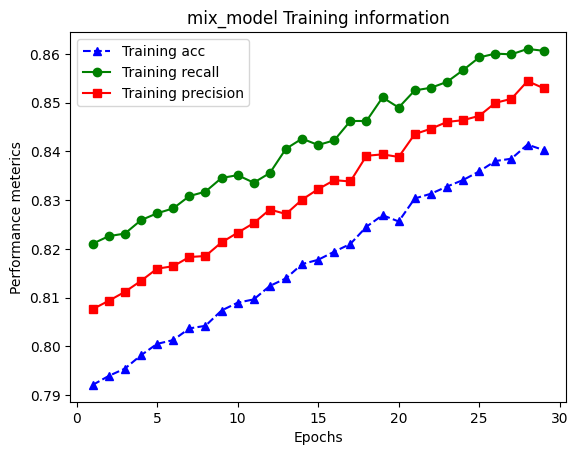

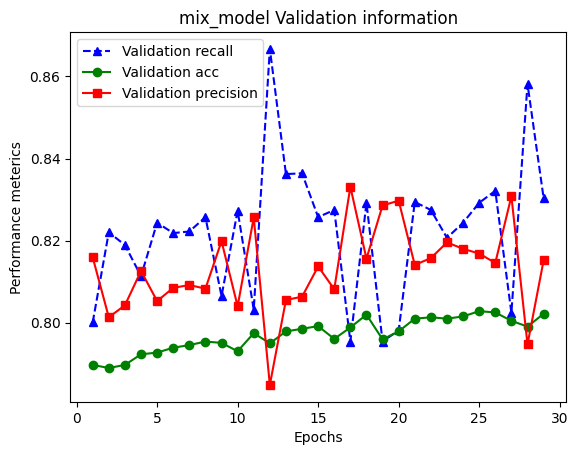

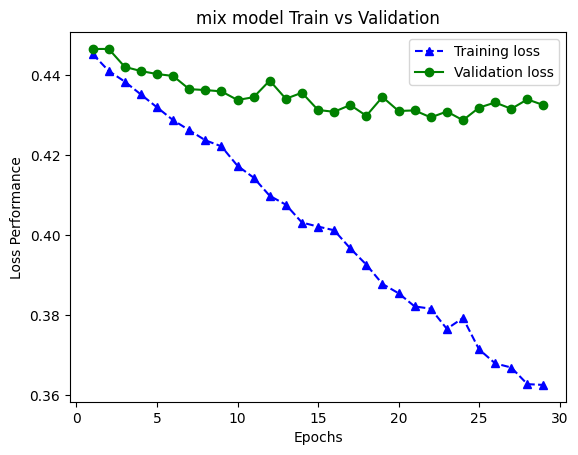

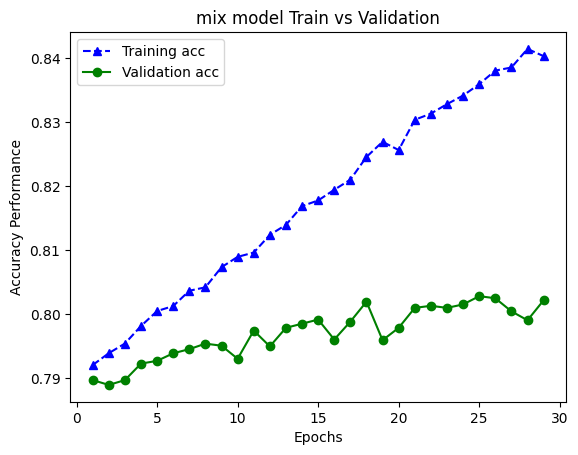

In [26]:
# Extract the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, 'b', linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, train_recall,'g', marker='o', label='Training recall')
plt.plot(epochs, train_precision, 'r', marker='s',label='Training precision')
plt.title('mix_model Training information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/mix_model_training")
plt.show()

plt.plot(epochs, val_recall, 'b',linestyle='--', marker='^', label='Validation recall')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('mix_model Validation information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/mix_model_validation")
plt.show()

plt.plot(epochs, train_loss, 'b',linestyle='--', marker='^', label='Training loss')
plt.plot(epochs, val_loss, 'g', marker='o', label='Validation loss')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('mix model Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss Performance')
plt.legend()
plt.savefig("../fig/mix_model_loss")
plt.show()

plt.plot(epochs, train_acc, 'b',linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('mix model Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Performance')
plt.legend()
plt.savefig("../fig/mix_model_acc")
plt.show()
#






In [23]:
mix_model.evaluate(X_test, y_test, verbose=0)

[0.6610138416290283,
 0.5757364630699158,
 0.6066837906837463,
 0.4829467833042145]

In [24]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           5000100   
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             16032     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                        

In [23]:

if crossvalidation == True:
  # Define the number of folds
  k = 5

  # Convert X_train and y_train to numpy arrays
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.astype('int')
  y_train = y_train.astype('int')


  # Define the cross-validation generator
  kf = KFold(n_splits=k)
  print(kf)

  # Loop over each fold
  for train_indices, val_indices in kf.split(X_train):

    
    print(len(train_indices))
    # Split the data into training and validation sets
    
    train_data, train_labels = X_train[train_indices], y_train[train_indices]
    val_data, val_labels = X_train[val_indices], y_train[val_indices]


    # Compile the model
    cnn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy',
                          'Precision', 'Recall'])

    # Train the model
    history = cnn_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10, batch_size=64, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    scores = cnn_model.evaluate(val_data, val_labels, verbose=0)

    # Print the validation scores for this fold
    print(scores[1])
    
  # Print the average validation score across all folds
  print("Average validation score: ", np.mean(scores))
else:
  history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=64, callbacks=[early_stopping])


Epoch 1/80
582/582 [==============================] - 3s 3ms/step - loss: 0.6673 - accuracy: 0.5914 - precision: 0.5929 - recall: 0.8370 - val_loss: 0.6036 - val_accuracy: 0.6856 - val_precision: 0.6678 - val_recall: 0.8691
Epoch 2/80
582/582 [==============================] - 2s 3ms/step - loss: 0.5680 - accuracy: 0.7142 - precision: 0.7172 - recall: 0.7990 - val_loss: 0.5321 - val_accuracy: 0.7381 - val_precision: 0.7442 - val_recall: 0.8085
Epoch 3/80
582/582 [==============================] - 2s 3ms/step - loss: 0.5299 - accuracy: 0.7418 - precision: 0.7588 - recall: 0.7826 - val_loss: 0.5166 - val_accuracy: 0.7487 - val_precision: 0.7609 - val_recall: 0.8016
Epoch 4/80
582/582 [==============================] - 2s 3ms/step - loss: 0.5151 - accuracy: 0.7519 - precision: 0.7721 - recall: 0.7835 - val_loss: 0.5086 - val_accuracy: 0.7555 - val_precision: 0.7664 - val_recall: 0.8081
Epoch 5/80
582/582 [==============================] - 2s 3ms/step - loss: 0.5021 - accuracy: 0.7604 - pr

In [24]:
y_pred = cnn_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Precision: 0.8058328440007829
Recall: 0.7923402617397999
F1 Score: 0.7990295972828725
ROC AUC Score: 0.8553409857288109


In [25]:
acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(cnn_model.metrics_names)
# acc
print('Test Accuracy: %f' % (acc[1]*100))

['loss', 'accuracy', 'precision', 'recall']
Test Accuracy: 77.757490


In [62]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.74      0.75      0.75      4144
    Positive       0.80      0.79      0.79      5167

    accuracy                           0.77      9311
   macro avg       0.77      0.77      0.77      9311
weighted avg       0.77      0.77      0.77      9311



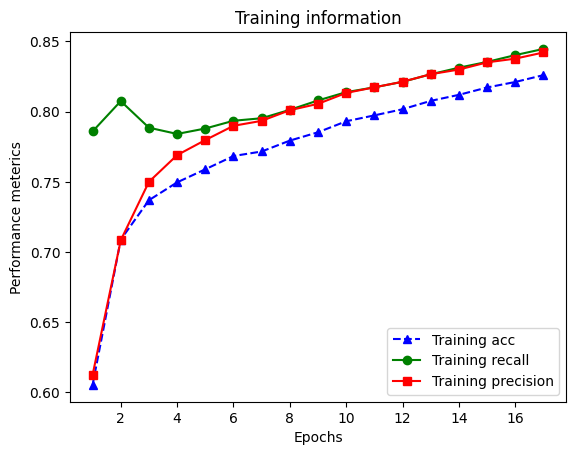

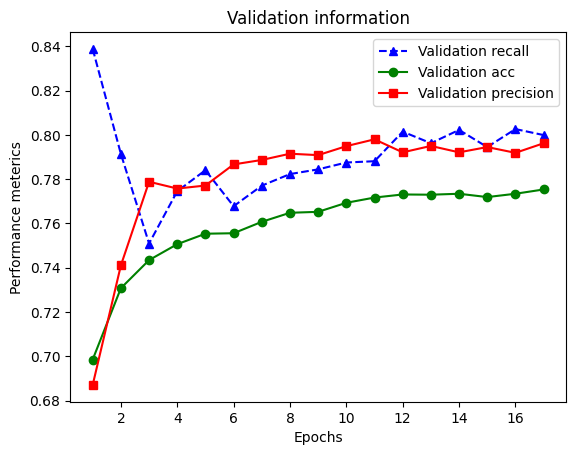

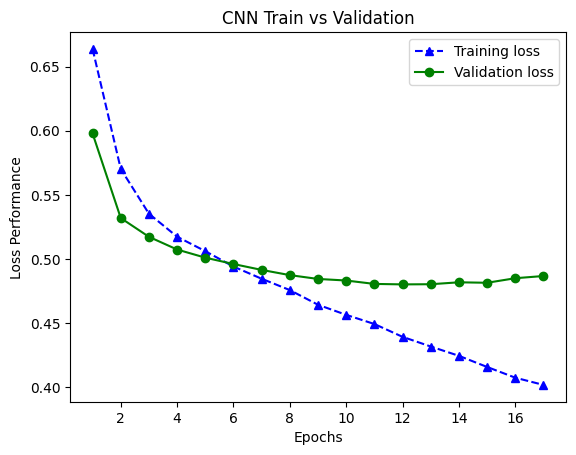

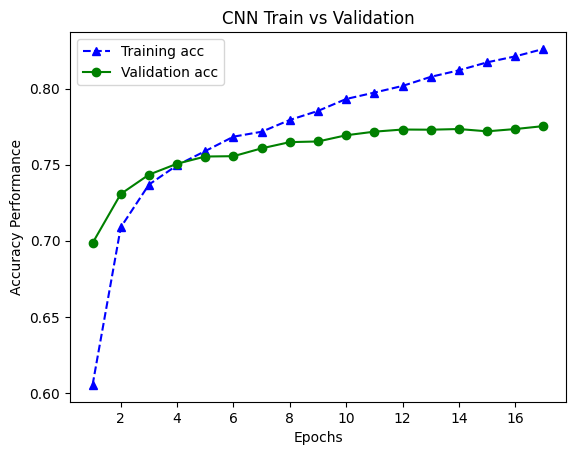

In [31]:
# Extract the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, 'b', linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, train_recall,'g', marker='o', label='Training recall')
plt.plot(epochs, train_precision, 'r', marker='s',label='Training precision')
plt.title('Training information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/cnn_model_training")
plt.show()

plt.plot(epochs, val_recall, 'b',linestyle='--', marker='^', label='Validation recall')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('Validation information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/cnn_model_validation")
plt.show()

plt.plot(epochs, train_loss, 'b',linestyle='--', marker='^', label='Training loss')
plt.plot(epochs, val_loss, 'g', marker='o', label='Validation loss')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('CNN Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss Performance')
plt.legend()
plt.savefig("../fig/cnn_model_loss")
plt.show()

plt.plot(epochs, train_acc, 'b',linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('CNN Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Performance')
plt.legend()
plt.savefig("../fig/cnn_model_acc")
plt.show()

#






In [32]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10, 100)           5000100   
                                                                 
 lstm_4 (LSTM)               (None, 32)                17024     
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,021,349
Trainable params: 21,249
Non-t

In [33]:
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
582/582 [==============================] - 6s 8ms/step - loss: 0.7102 - accuracy: 0.5236 - precision: 0.5561 - recall: 0.6990 - val_loss: 0.6905 - val_accuracy: 0.5549 - val_precision: 0.5549 - val_recall: 1.0000
Epoch 2/50
582/582 [==============================] - 4s 8ms/step - loss: 0.6376 - accuracy: 0.6233 - precision: 0.6385 - recall: 0.7396 - val_loss: 0.5570 - val_accuracy: 0.7129 - val_precision: 0.7228 - val_recall: 0.7829
Epoch 3/50
582/582 [==============================] - 4s 8ms/step - loss: 0.5566 - accuracy: 0.7148 - precision: 0.7361 - recall: 0.7573 - val_loss: 0.5399 - val_accuracy: 0.7208 - val_precision: 0.7232 - val_recall: 0.8049
Epoch 4/50
582/582 [==============================] - 4s 7ms/step - loss: 0.5435 - accuracy: 0.7227 - precision: 0.7457 - recall: 0.7587 - val_loss: 0.5334 - val_accuracy: 0.7238 - val_precision: 0.7273 - val_recall: 0.8036
Epoch 5/50
582/582 [==============================] - 4s 8ms/step - loss: 0.5373 - accuracy: 0.7282 - pr

In [35]:
y_pred = lstm_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Precision: 0.7984196986402058
Recall: 0.8409134894522934
F1 Score: 0.8191158450372327
ROC AUC Score: 0.8707602607653411


In [34]:
acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(lstm_model.metrics_names)
# acc
print('Test Accuracy: %f' % (acc[1]*100))

['loss', 'accuracy', 'precision', 'recall']
Test Accuracy: 79.389971


In [36]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.79      0.74      0.76      4144
    Positive       0.80      0.84      0.82      5167

    accuracy                           0.79      9311
   macro avg       0.79      0.79      0.79      9311
weighted avg       0.79      0.79      0.79      9311



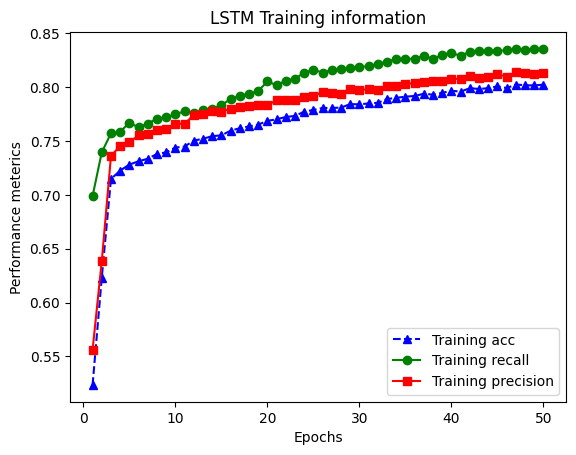

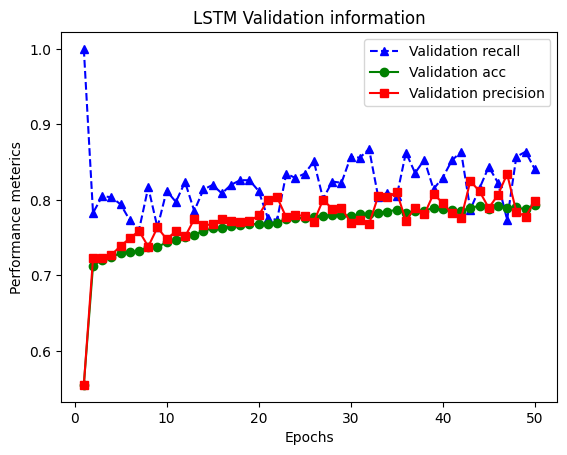

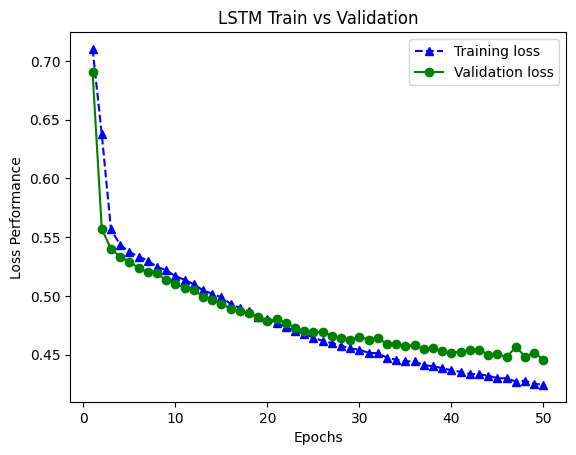

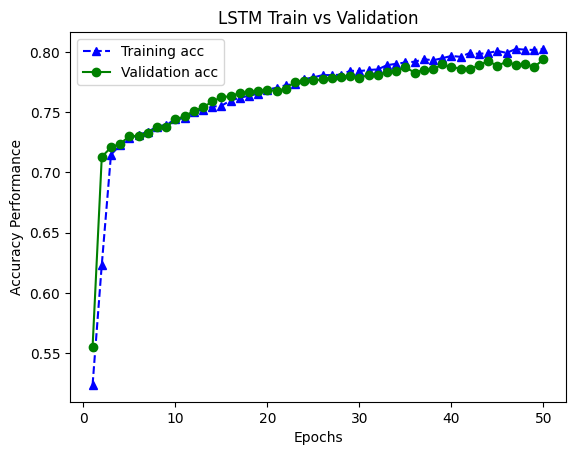

In [37]:
# Extract the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, 'b', linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, train_recall,'g', marker='o', label='Training recall')
plt.plot(epochs, train_precision, 'r', marker='s',label='Training precision')
plt.title('LSTM Training information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/lstm_model_training")
plt.show()

plt.plot(epochs, val_recall, 'b',linestyle='--', marker='^', label='Validation recall')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('LSTM Validation information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/lstm_model_validation")
plt.show()

plt.plot(epochs, train_loss, 'b',linestyle='--', marker='^', label='Training loss')
plt.plot(epochs, val_loss, 'g', marker='o', label='Validation loss')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('LSTM Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss Performance')
plt.legend()
plt.savefig("../fig/lstm_model_loss")
plt.show()

plt.plot(epochs, train_acc, 'b',linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('LSTM Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Performance')
plt.legend()
plt.savefig("../fig/lstm_model_acc")
plt.show()

In [38]:
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 10, 100)           5000100   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                      

In [41]:
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
582/582 [==============================] - 4s 5ms/step - loss: 1.0047 - accuracy: 0.6917 - precision: 0.7217 - recall: 0.7228 - val_loss: 0.7377 - val_accuracy: 0.7092 - val_precision: 0.6751 - val_recall: 0.9174
Epoch 2/50
582/582 [==============================] - 3s 4ms/step - loss: 0.6382 - accuracy: 0.7305 - precision: 0.7586 - recall: 0.7541 - val_loss: 0.6429 - val_accuracy: 0.6985 - val_precision: 0.6633 - val_recall: 0.9278
Epoch 3/50
582/582 [==============================] - 3s 5ms/step - loss: 0.5747 - accuracy: 0.7319 - precision: 0.7594 - recall: 0.7563 - val_loss: 0.5769 - val_accuracy: 0.7130 - val_precision: 0.8347 - val_recall: 0.6021
Epoch 4/50
582/582 [==============================] - 3s 5ms/step - loss: 0.5626 - accuracy: 0.7327 - precision: 0.7626 - recall: 0.7523 - val_loss: 0.5527 - val_accuracy: 0.7245 - val_precision: 0.8156 - val_recall: 0.6507
Epoch 5/50
582/582 [==============================] - 3s 5ms/step - loss: 0.5585 - accuracy: 0.7334 - pr

In [42]:
y_pred = rnn_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Precision: 0.7501373877999634
Recall: 0.7925295142248887
F1 Score: 0.7707509881422925
ROC AUC Score: 0.8171084101810345


In [43]:
acc = rnn_model.evaluate(X_test, y_test, verbose=0)
print(rnn_model.metrics_names)
# acc
print('Test Accuracy: %f' % (acc[1]*100))

['loss', 'accuracy', 'precision', 'recall']
Test Accuracy: 73.837399


In [44]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.72      0.67      0.70      4144
    Positive       0.75      0.79      0.77      5167

    accuracy                           0.74      9311
   macro avg       0.74      0.73      0.73      9311
weighted avg       0.74      0.74      0.74      9311



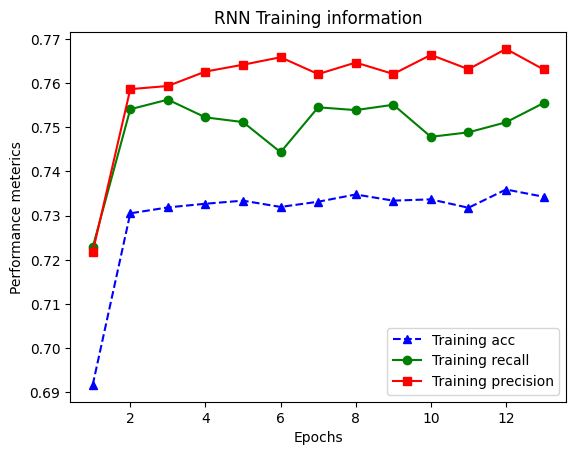

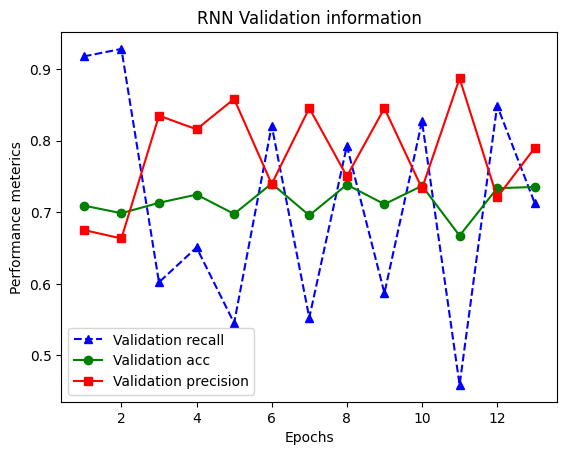

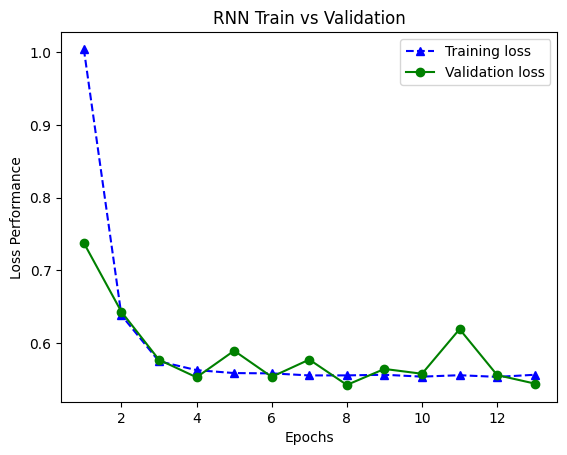

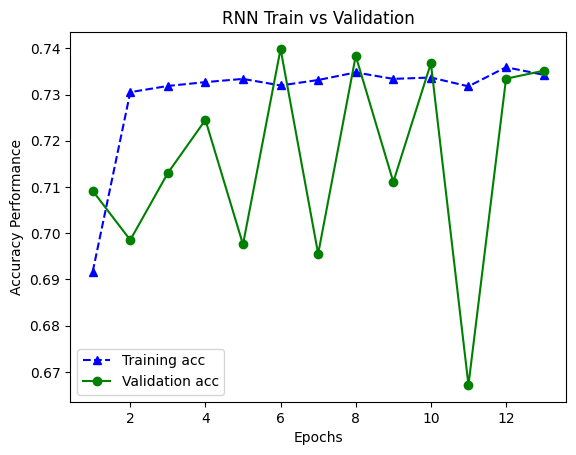

In [45]:
# Extract the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, 'b', linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, train_recall,'g', marker='o', label='Training recall')
plt.plot(epochs, train_precision, 'r', marker='s',label='Training precision')
plt.title('RNN Training information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/rnn_model_training")
plt.show()

plt.plot(epochs, val_recall, 'b',linestyle='--', marker='^', label='Validation recall')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('RNN Validation information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/rnn_model_validation")
plt.show()

plt.plot(epochs, train_loss, 'b',linestyle='--', marker='^', label='Training loss')
plt.plot(epochs, val_loss, 'g', marker='o', label='Validation loss')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('RNN Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss Performance')
plt.legend()
plt.savefig("../fig/rnn_model_loss")
plt.show()

plt.plot(epochs, train_acc, 'b',linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('RNN Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Performance')
plt.legend()
plt.savefig("../fig/rnn_model_acc")
plt.show()

In [46]:
gru_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 10, 100)           5000100   
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,012,997
Trainable params: 12,897
Non-trainable params: 5,000,100
_________________________________________________________________


In [47]:
history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
582/582 [==============================] - 9s 10ms/step - loss: 0.5641 - accuracy: 0.6982 - precision: 0.7018 - recall: 0.7925 - val_loss: 0.5138 - val_accuracy: 0.7391 - val_precision: 0.7459 - val_recall: 0.8038
Epoch 2/50
582/582 [==============================] - 5s 8ms/step - loss: 0.5263 - accuracy: 0.7328 - precision: 0.7511 - recall: 0.7752 - val_loss: 0.5018 - val_accuracy: 0.7517 - val_precision: 0.7825 - val_recall: 0.7652
Epoch 3/50
582/582 [==============================] - 5s 8ms/step - loss: 0.5100 - accuracy: 0.7488 - precision: 0.7675 - recall: 0.7848 - val_loss: 0.4896 - val_accuracy: 0.7581 - val_precision: 0.7471 - val_recall: 0.8529
Epoch 4/50
582/582 [==============================] - 4s 8ms/step - loss: 0.4984 - accuracy: 0.7534 - precision: 0.7725 - recall: 0.7872 - val_loss: 0.4790 - val_accuracy: 0.7722 - val_precision: 0.7620 - val_recall: 0.8572
Epoch 5/50
582/582 [==============================] - 5s 8ms/step - loss: 0.4858 - accuracy: 0.7630 - p

In [48]:
y_pred = gru_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Precision: 0.8375644206909716
Recall: 0.849235533191407
F1 Score: 0.8433596002306362
ROC AUC Score: 0.90017977262147


In [49]:
acc = gru_model.evaluate(X_test, y_test, verbose=0)
print(gru_model.metrics_names)
# acc
print('Test Accuracy: %f' % (acc[1]*100))

['loss', 'accuracy', 'precision', 'recall']
Test Accuracy: 82.493824


In [50]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80      4144
    Positive       0.84      0.85      0.84      5167

    accuracy                           0.82      9311
   macro avg       0.82      0.82      0.82      9311
weighted avg       0.82      0.82      0.82      9311



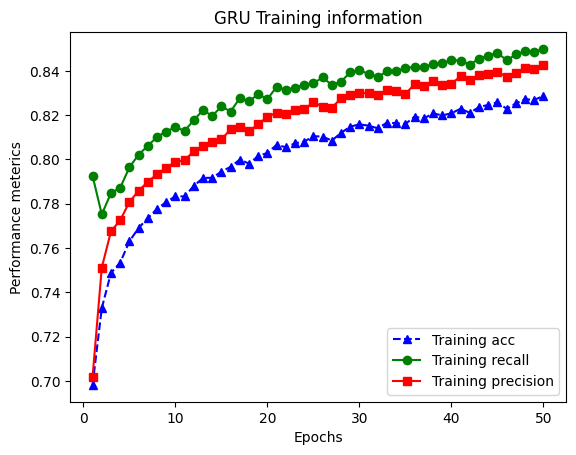

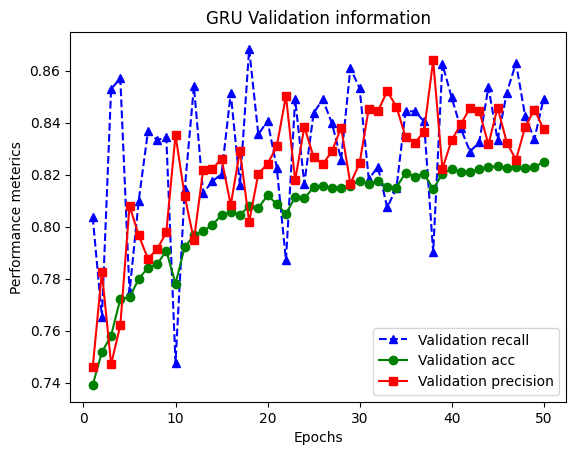

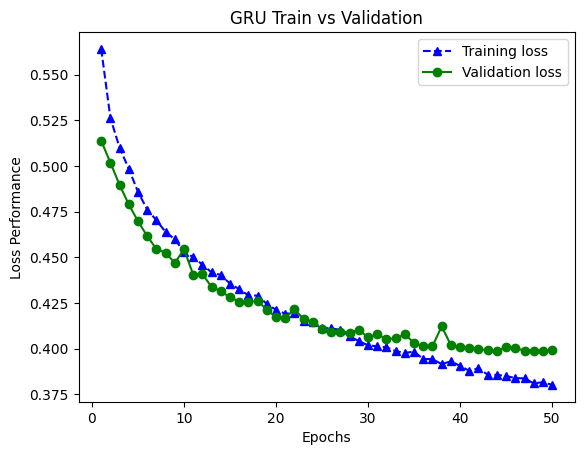

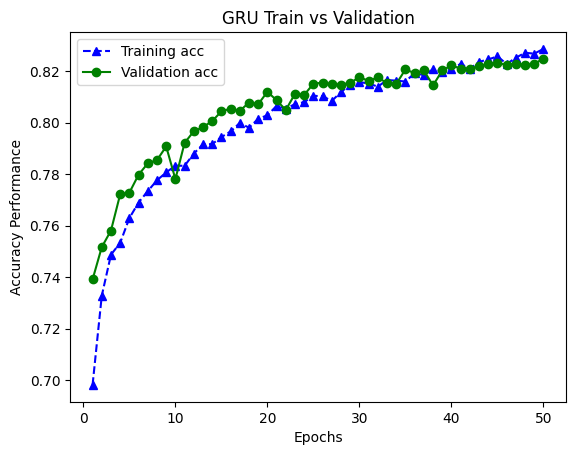

In [51]:
# Extract the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, 'b', linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, train_recall,'g', marker='o', label='Training recall')
plt.plot(epochs, train_precision, 'r', marker='s',label='Training precision')
plt.title('GRU Training information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/gru_model_training")
plt.show()

plt.plot(epochs, val_recall, 'b',linestyle='--', marker='^', label='Validation recall')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('GRU Validation information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/gru_model_validation")
plt.show()

plt.plot(epochs, train_loss, 'b',linestyle='--', marker='^', label='Training loss')
plt.plot(epochs, val_loss, 'g', marker='o', label='Validation loss')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('GRU Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss Performance')
plt.legend()
plt.savefig("../fig/gru_model_loss")
plt.show()

plt.plot(epochs, train_acc, 'b',linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('GRU Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Performance')
plt.legend()
plt.savefig("../fig/gru_model_acc")
plt.show()

In [52]:
bilstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 10, 100)           5000100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,036,261
Trainable params: 36,161
Non-trainable params: 5,000,100
_______________________________________

In [53]:
history = bilstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, callbacks=[early_stopping])

Epoch 1/60
582/582 [==============================] - 12s 13ms/step - loss: 0.8570 - accuracy: 0.6789 - precision: 0.6763 - recall: 0.8076 - val_loss: 0.5603 - val_accuracy: 0.7248 - val_precision: 0.8006 - val_recall: 0.6714
Epoch 2/60
582/582 [==============================] - 7s 12ms/step - loss: 0.5732 - accuracy: 0.7211 - precision: 0.7466 - recall: 0.7525 - val_loss: 0.5516 - val_accuracy: 0.7303 - val_precision: 0.7915 - val_recall: 0.6979
Epoch 3/60
582/582 [==============================] - 7s 13ms/step - loss: 0.5663 - accuracy: 0.7220 - precision: 0.7563 - recall: 0.7360 - val_loss: 0.5407 - val_accuracy: 0.7305 - val_precision: 0.7617 - val_recall: 0.7486
Epoch 4/60
582/582 [==============================] - 7s 12ms/step - loss: 0.5624 - accuracy: 0.7232 - precision: 0.7603 - recall: 0.7316 - val_loss: 0.5453 - val_accuracy: 0.7347 - val_precision: 0.7297 - val_recall: 0.8291
Epoch 5/60
582/582 [==============================] - 7s 12ms/step - loss: 0.5547 - accuracy: 0.725

In [54]:
y_pred = bilstm.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Precision: 0.775808336579665
Recall: 0.7708534933230115
F1 Score: 0.7733229783516163
ROC AUC Score: 0.8337554866307044


In [55]:
acc = bilstm.evaluate(X_test, y_test, verbose=0)
print(bilstm.metrics_names)
# acc
print('Test Accuracy: %f' % (acc[1]*100))

['loss', 'accuracy', 'precision', 'recall']
Test Accuracy: 74.922132


In [56]:
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      4144
    Positive       0.78      0.77      0.77      5167

    accuracy                           0.75      9311
   macro avg       0.75      0.75      0.75      9311
weighted avg       0.75      0.75      0.75      9311



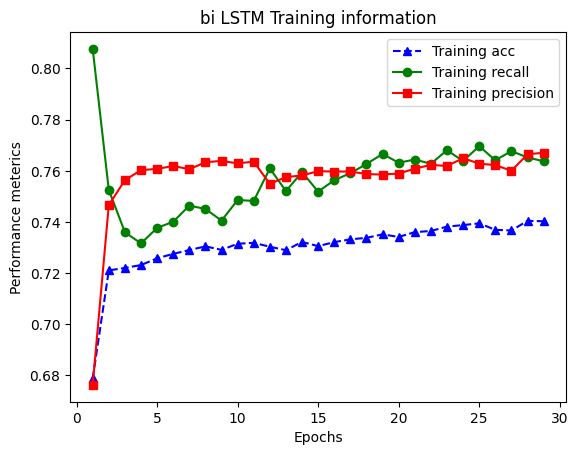

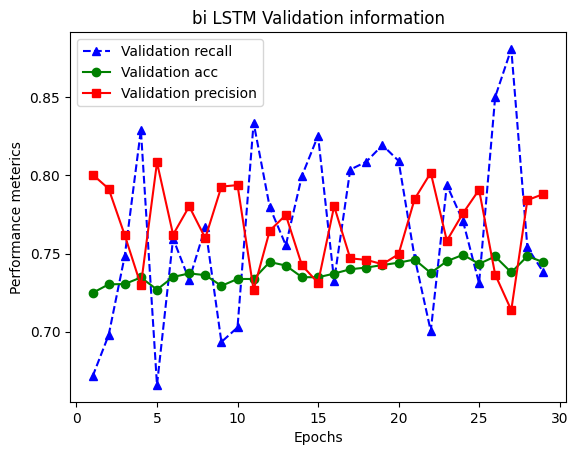

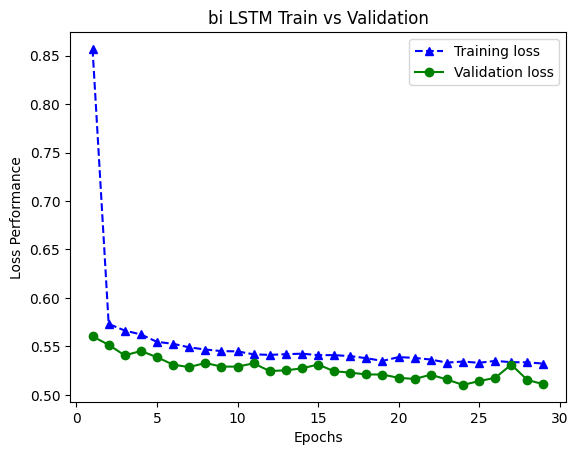

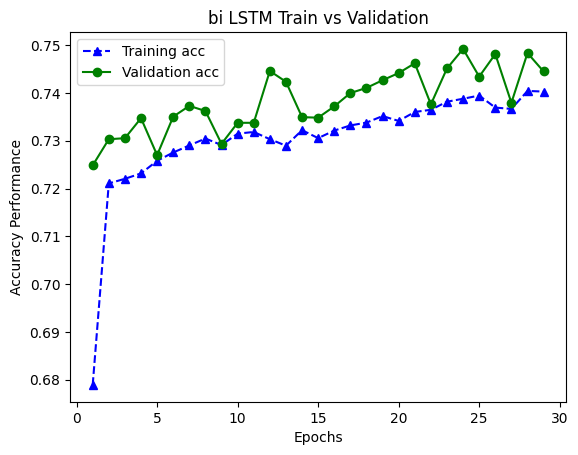

In [57]:
# Extract the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, 'b', linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, train_recall,'g', marker='o', label='Training recall')
plt.plot(epochs, train_precision, 'r', marker='s',label='Training precision')
plt.title('bi LSTM Training information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/bilstm_model_training")
plt.show()

plt.plot(epochs, val_recall, 'b',linestyle='--', marker='^', label='Validation recall')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('bi LSTM Validation information')
plt.xlabel('Epochs')
plt.ylabel('Performance meterics')
plt.legend()
plt.savefig("../fig/bilstm_model_validation")
plt.show()

plt.plot(epochs, train_loss, 'b',linestyle='--', marker='^', label='Training loss')
plt.plot(epochs, val_loss, 'g', marker='o', label='Validation loss')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('bi LSTM Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss Performance')
plt.legend()
plt.savefig("../fig/bilstm_model_loss")
plt.show()

plt.plot(epochs, train_acc, 'b',linestyle='--', marker='^', label='Training acc')
plt.plot(epochs, val_acc, 'g', marker='o', label='Validation acc')
# plt.plot(epochs, val_precision, 'r', marker='s', label='Validation precision')
plt.title('bi LSTM Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Performance')
plt.legend()
plt.savefig("../fig/bilstm_model_acc")
plt.show()